## Simple 3D autoencoder for the neuron - cosmic web project. 

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

import tensorflow as tf

from keras.utils import np_utils
from keras.models import Model
from keras.layers import *
from keras.optimizers import Adam, SGD, Adadelta
from keras.layers import Conv3D, MaxPooling3D, Conv3DTranspose, UpSampling3D
from keras.layers import Input, BatchNormalization, Flatten, Dense, Dropout, Activation
from keras import optimizers as opt
from keras.callbacks import ModelCheckpoint
from keras.metrics import mean_squared_error, mean_absolute_error
from keras import backend as K

Using TensorFlow backend.


In [2]:
K.set_image_data_format('channels_last')  # TF dimension ordering in this code
np.random.seed(1234567)

In [3]:
#--- Limit ammount of memory used by tensorflow
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)

In [4]:
#import sys
#sys.path.insert(0, '/home/miguel/.local/python_utils/')
#import Imaging.utils_imaging as utils_imaging
#import utils_idl as idl
#from utils_various import info as info
#from Imaging.image_grids import show_image_row as show_image_row

***

In [5]:
#========================================================
#  Simple routine to show a row of n images
#  _imas is a list of images
#========================================================
def show_image_row(_imas, _plot_size=None):

    if (_plot_size != None):
        plt.rcParams['figure.figsize'] = [_plot_size[0], _plot_size[1]]

    ncols = len(_imas)
    fig, axes = plt.subplots(nrows=1, ncols=ncols)
    ax = axes.ravel()

    for i in range(ncols):
        ax[i].imshow(_imas[i], cmap='gray')
        ax[i].axis('off')
        
    plt.tight_layout()
    plt.show()



In [6]:
#---------------------------------------------------------
#   Read cube of chars
#---------------------------------------------------------
def read_bvolume(filename):
    import struct
    import array as arr
    
    F = open(filename,'rb')
    
    #--- Read header
    head = F.read(256)
    (sizeX,) = struct.unpack('i',head[12:16])
    (sizeY,) = struct.unpack('i',head[16:20])
    (sizeZ,) = struct.unpack('i',head[20:24])    
    print('>>> Reading volume of size:', sizeX,sizeY,sizeZ)
    
    den = arr.array('b')
    den.fromfile(F,sizeX*sizeY*sizeZ)
    F.close()    
    den = np.array(den).reshape((sizeX,sizeY,sizeZ)).astype(np.uint8)
    
    return den

In [7]:
#---------------------------------------------------------
#   Project a cuve along a given axis
#---------------------------------------------------------
def project_volu(vol, lim1, lim2, ax):
    shp = vol.shape
    out = np.zeros(shape=(shp[0], shp[1]))
    
    for i in range(lim1,lim2):
        if (ax == 0):
            out = out + vol[i,:,:]
        if (ax == 1):
            out = out + vol[:,i,:]
        if (ax == 2):
            out = out + vol[:,:,i]            
    return out

In [8]:
#---------------------------------------------------------
#  Un-pythonic cube rotation
#---------------------------------------------------------
def rotate_cube(vol, ax, new=False):
    shp = vol.shape

    if (ax == 0):
        for i in range(shp[0]):
            vol[i,:,:] = np.rot90(vol[i,:,:])
    if (ax == 1):
        for i in range(shp[1]):
            vol[:,i,:] = np.rot90(vol[:,i,:])
    if (ax == 2):
        for i in range(shp[2]):
            vol[:,:,i] = np.rot90(vol[:,:,i])
    return vol

In [9]:
#---------------------------------------------------------
#
#---------------------------------------------------------
def save_history(history, filename):
    all_array = []
    all_array.append(history.history)
    #--- Write to disk, close file out of paranoia
    f = open(filename, 'wb')
    pickle.dump(all_array, f)
    f.close()

In [10]:
#---------------------------------------------------------
#
#---------------------------------------------------------
def load_dataset_all(_FILE_DEN, _SUBGRID):

    #--- Read and rescale density field
    den = read_bvolume(_FILE_DEN).astype('float32')
    #den = den / np.mean(den)
    den = den - np.min(den)
    den = den / np.max(den)
    
    #--- Number of bins
    n_bins = den.shape[0] // _SUBGRID
    
    n_rotations = 4   # Simple data augmentation, rotate cube along axis    
    X_all = np.zeros(shape=((n_bins**3)*n_rotations, SUBGRID,SUBGRID,SUBGRID,1))
    
    cont = 0
    for i in range(n_bins):
        for j in range(n_bins):
            for k in range(n_bins):
                
                sub_den = den[i*SUBGRID:(i+1)*SUBGRID, j*SUBGRID:(j+1)*SUBGRID, k*SUBGRID:(k+1)*SUBGRID]
                X_all[cont,:,:,:,0] = sub_den
                cont = cont+1

                sub_den = den[i*SUBGRID:(i+1)*SUBGRID, j*SUBGRID:(j+1)*SUBGRID, k*SUBGRID:(k+1)*SUBGRID]
                sub_den = rotate_cube(sub_den,2)
                X_all[cont,:,:,:,0] = sub_den
                cont = cont+1

                sub_den = den[i*SUBGRID:(i+1)*SUBGRID, j*SUBGRID:(j+1)*SUBGRID, k*SUBGRID:(k+1)*SUBGRID]
                sub_den = rotate_cube(sub_den,1)
                X_all[cont,:,:,:,0] = sub_den
                cont = cont+1

                sub_den = den[i*SUBGRID:(i+1)*SUBGRID, j*SUBGRID:(j+1)*SUBGRID, k*SUBGRID:(k+1)*SUBGRID]
                sub_den = rotate_cube(sub_den,0)
                X_all[cont,:,:,:,0] = sub_den
                cont = cont+1
                
        print('>>> Loading subcube ', i,j,k)
    
    return X_all


In [11]:
#---------------------------------------------------------
# Autoencoder, to change its depth add/remove layers in a symmetric way.
#---------------------------------------------------------
def get_net(input_shape, kernel):
    inputs = Input(shape=input_shape, name="input_1")
    x = inputs

    strides_1 = (1,1,1)
    strides_2 = (2,2,2)
    
    encode1a = Conv3D(filters=64, kernel_size=kernel, activation='relu', padding='same', name='encode1a', strides=strides_1)(x)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2), strides=strides_2, padding='same', name='pool1')(encode1a)

    encode2a = Conv3D(filters=128, kernel_size=kernel, activation='relu', padding='same', name='encode2a', strides=strides_1)(pool1)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2), strides=strides_2, padding='same', name='pool2')(encode2a)

    encode3a = Conv3D(filters=256, kernel_size=kernel, activation='relu', padding='same', name='encode3a', strides=strides_1)(pool2)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2), strides=strides_2, padding='same', name='pool3')(encode3a)
    
    #--------------------------

    #bottom_a = Conv3D(filters=512, kernel_size=kernel, activation='relu', padding='same')(pool3)
    #bottom_b = Conv3D(filters=512, kernel_size=kernel, activation='relu', padding='same')(bottom_a)

    #--------------------------
    
    up3   = Conv3DTranspose(filters=256, kernel_size=(2,2,2), strides=strides_2, padding='same')(pool3)
    decode3a = Conv3D(filters=256, kernel_size=kernel, activation='relu', padding='same', name='decode3a', strides=strides_1)(up3)    
    
    up2   = Conv3DTranspose(filters=128, kernel_size=(2,2,2), strides=strides_2, padding='same')(decode3a)
    decode2a = Conv3D(filters=128, kernel_size=kernel, activation='relu', padding='same', name='decode2a', strides=strides_1)(up2)

    up1   = Conv3DTranspose(filters=64, kernel_size=(2,2,2), strides=strides_2, padding='same')(decode2a)
    decode1a = Conv3D(filters=64, kernel_size=kernel, activation='relu', padding='same', name='decode1a', strides=strides_1)(up1)
    
    
    flatten = Convolution3D(filters=1, kernel_size=(1, 1, 1), activation='sigmoid')(decode1a)

    model = Model(inputs=inputs, outputs=flatten)
    
    model.compile(optimizer=Adadelta(), loss='mse', metrics=['mse'])

    return model


***

In [12]:
#--- Grid size of input density field
GRID    = 256

#--- Because of memory constraints we will process the cube into subcubes this size
SUBGRID = 64

#--- Density field
FILE_DENSITY = 'Data/Bolshoi_sub-1.bvol'

#--- Load datafile, break into sub-cubes and rotate for data aumentation
X_train = load_dataset_all(FILE_DENSITY, SUBGRID)

>>> Reading volume of size: 256 256 256
>>> Loading subcube  0 3 3
>>> Loading subcube  1 3 3
>>> Loading subcube  2 3 3
>>> Loading subcube  3 3 3


In [13]:
#--- Create model, use None as input size so we can later predict for any input cube
model = get_net((None,None,None,1), (3,3,3))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, None,  0         
_________________________________________________________________
encode1a (Conv3D)            (None, None, None, None,  1792      
_________________________________________________________________
pool1 (MaxPooling3D)         (None, None, None, None,  0         
_________________________________________________________________
encode2a (Conv3D)            (None, None, None, None,  221312    
_________________________________________________________________
pool2 (MaxPooling3D)         (None, None, None, None,  0         
_________________________________________________________________
encode3a (Conv3D)            (None, None, None, None,  884992    
_________________________________________________________________
pool3 (MaxPooling3D)         (None, None, None, None,  0         
__________

## Model training

### Interestingly training with a batch size of 1 gives better results than larger batch (I tried 4 and 8)

### Be aware of the high GPU memory requirements of this network.

In [14]:
model_checkpoint = ModelCheckpoint('model_1.h5', monitor='val_loss', save_best_only=True)

history = model.fit(X_train, X_train, batch_size=1, epochs=20, verbose=1, shuffle=True,validation_split=0.2, callbacks=[model_checkpoint])

save_history(history, 'mode_1.history.pkl')


Train on 204 samples, validate on 52 samples
Epoch 1/20
204/204 [==============================] - 52s 254ms/step - loss: 0.0143 - mean_squared_error: 0.0143 - val_loss: 0.0110 - val_mean_squared_error: 0.0110
Epoch 2/20
204/204 [==============================] - 49s 242ms/step - loss: 0.0112 - mean_squared_error: 0.0112 - val_loss: 0.0108 - val_mean_squared_error: 0.0108
Epoch 3/20
204/204 [==============================] - 50s 243ms/step - loss: 0.0111 - mean_squared_error: 0.0111 - val_loss: 0.0107 - val_mean_squared_error: 0.0107
Epoch 4/20
204/204 [==============================] - 50s 243ms/step - loss: 0.0110 - mean_squared_error: 0.0110 - val_loss: 0.0106 - val_mean_squared_error: 0.0106
Epoch 5/20
204/204 [==============================] - 50s 246ms/step - loss: 0.0108 - mean_squared_error: 0.0108 - val_loss: 0.0104 - val_mean_squared_error: 0.0104
Epoch 6/20
204/204 [==============================] - 51s 249ms/step - loss: 0.0096 - mean_squared_error: 0.0096 - val_loss: 0.008

### The plot below shows the loss as a function of the training epochs. After 20 epochs the loss begins to flatten. 

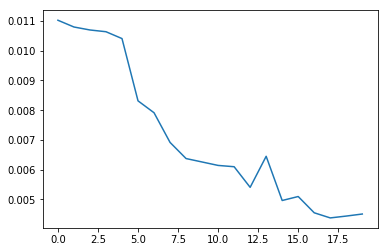

In [16]:
plt.plot(history.history['val_loss'])
plt.show()

## Predict some images. 

### We are reusing trainig images so this is in principle cheating but for our purpose it is ok since we only want to know if the network is able to reproduce the input meaning that it can form an internal representation of the features in the data

In [17]:


#model.load_weights('model_1.h5')

Y_pred  = model.predict(X_train[0:16,:,:,:,:], batch_size=1, verbose = 0)


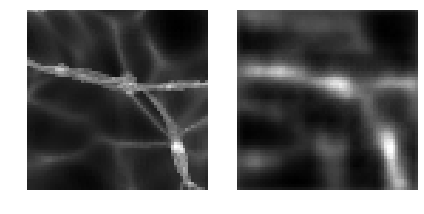

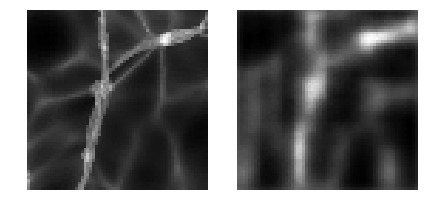

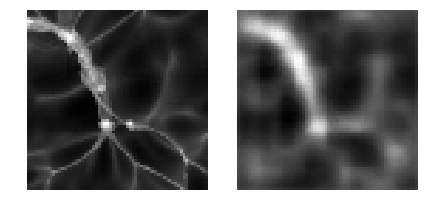

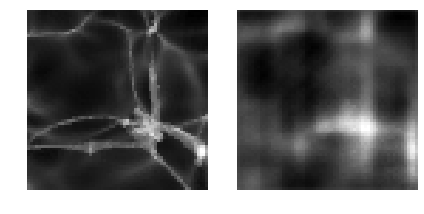

In [20]:
#--- Comparison between the original and predicted cubes. Show a thin slice across the z-axis
slice_k = 32
for i in range(4):
    show_image_row([X_train[i,:,:,slice_k,0], Y_pred[i,:,:,slice_k,0]])